In [5]:
import os
import numpy as np
import scipy
from scipy.io import wavfile
import scipy.fftpack as fft
from scipy.signal import get_window
import IPython.display as ipd
import matplotlib.pyplot as plt
from pathlib import Path

%matplotlib inline

## 读取文件

In [110]:
TRAIN_PATH = '../../dataset/trainset/'
labels = [ 'down', 'go', 'left', 'no', 'off', 'on', 'right', 'stop', 'up', 'yes']

In [111]:
file_names = []

path = TRAIN_PATH + labels[0] + '/'
pathname = Path(path)

for cp in pathname.iterdir():
    term = Path(cp)
    file_names.append(term.name)

In [112]:
test_file = path + file_names[0]

In [27]:
ipd.Audio(test_file)

## MFCC

In [29]:
def normalize_audio(audio):
    audio = audio / np.max(np.abs(audio))
    return audio

In [95]:
def frame_audio(audio, FFT_size=2048, hop_size=10, sample_rate=16000):
    # hop_size in ms
    
    audio = np.pad(audio, int(FFT_size / 2), mode='reflect')
    frame_len = np.round(sample_rate * hop_size / 1000).astype(int)
    frame_num = int((len(audio) - FFT_size) / frame_len) + 1
    frames = np.zeros((frame_num,FFT_size))
    
    for n in range(frame_num):
        frames[n] = audio[n*frame_len:n*frame_len+FFT_size]
    
    return frames

In [81]:
def freq_to_mel(freq):
    return 2595.0 * np.log10(1.0 + freq / 700.0)

def met_to_freq(mels):
    return 700.0 * (10.0**(mels / 2595.0) - 1.0)

In [82]:
def get_filter_points(fmin, fmax, mel_filter_num, FFT_size, sample_rate=44100):
    fmin_mel = freq_to_mel(fmin)
    fmax_mel = freq_to_mel(fmax)
    
    print("MEL min: {0}".format(fmin_mel))
    print("MEL max: {0}".format(fmax_mel))
    
    mels = np.linspace(fmin_mel, fmax_mel, num=mel_filter_num+2)
    freqs = met_to_freq(mels)
    
    return np.floor((FFT_size + 1) / sample_rate * freqs).astype(int), freqs

In [84]:
def get_filters(filter_points, FFT_size):
    filters = np.zeros((len(filter_points)-2,int(FFT_size/2+1)))
    
    for n in range(len(filter_points)-2):
        filters[n, filter_points[n] : filter_points[n + 1]] = np.linspace(0, 1, filter_points[n + 1] - filter_points[n])
        filters[n, filter_points[n + 1] : filter_points[n + 2]] = np.linspace(1, 0, filter_points[n + 2] - filter_points[n + 1])
    
    return filters

In [89]:
def dct(dct_filter_num, filter_len):
    basis = np.empty((dct_filter_num,filter_len))
    basis[0, :] = 1.0 / np.sqrt(filter_len)
    
    samples = np.arange(1, 2 * filter_len, 2) * np.pi / (2.0 * filter_len)

    for i in range(1, dct_filter_num):
        basis[i, :] = np.cos(i * samples) * np.sqrt(2.0 / filter_len)
        
    return basis

In [118]:
def get_mfcc(test_file,hop_size = 20,FFT_size = 2048):
    sample_rate, audio = wavfile.read(test_file)
    
    audio = normalize_audio(audio)
    
    audio_framed = frame_audio(audio, FFT_size=FFT_size, hop_size=hop_size, sample_rate=sample_rate)
    window = get_window("hann", FFT_size, fftbins=True)
    
    audio_win = audio_framed * window
    audio_winT = np.transpose(audio_win)

    audio_fft = np.empty((int(1 + FFT_size // 2), audio_winT.shape[1]), dtype=np.complex64, order='F')

    for n in range(audio_fft.shape[1]):
        audio_fft[:, n] = fft.fft(audio_winT[:, n], axis=0)[:audio_fft.shape[0]]

    audio_fft = np.transpose(audio_fft)
    
    audio_power = np.square(np.abs(audio_fft))
    
    freq_min = 0
    freq_high = sample_rate / 2
    mel_filter_num = 10
    
    filter_points, mel_freqs = get_filter_points(freq_min, freq_high, mel_filter_num, FFT_size, sample_rate=sample_rate)
    filters = get_filters(filter_points, FFT_size)
    
    enorm = 2.0 / (mel_freqs[2:mel_filter_num+2] - mel_freqs[:mel_filter_num])
    filters *= enorm[:, np.newaxis]
    
    audio_filtered = np.dot(filters, np.transpose(audio_power))
    audio_log = 10.0 * np.log10(audio_filtered)
    
    
    dct_filter_num = 13

    dct_filters = dct(dct_filter_num, mel_filter_num)

    cepstral_coefficents = np.dot(dct_filters, audio_log)
    
    return cepstral_coefficents
    

In [28]:
sample_rate, audio = wavfile.read(test_file)
print("Sample rate: {0}Hz".format(sample_rate))
print("Audio duration: {0}s".format(len(audio) / sample_rate))

Sample rate: 16000Hz
Audio duration: 1.0s


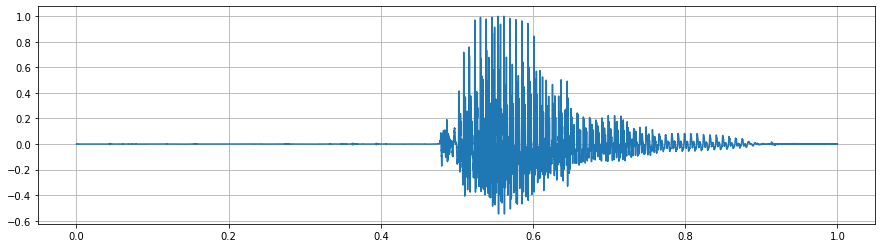

In [30]:
audio = normalize_audio(audio)
plt.figure(figsize=(15,4))
plt.plot(np.linspace(0, len(audio) / sample_rate, num=len(audio)), audio)
plt.grid(True)

In [74]:
hop_size = 20 #ms
FFT_size = 2048

audio_framed = frame_audio(audio, FFT_size=FFT_size, hop_size=hop_size, sample_rate=sample_rate)
print("Framed audio shape: {0}".format(audio_framed.shape))

Framed audio shape: (51, 2048)


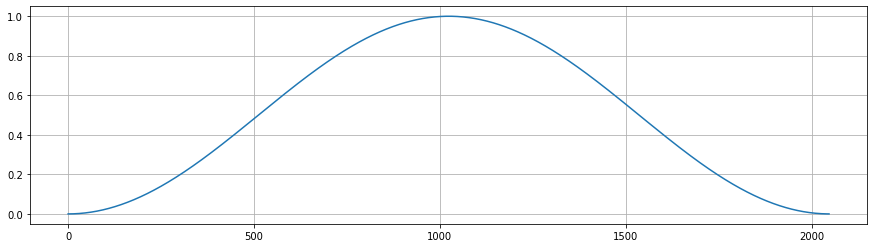

In [75]:
window = get_window("hann", FFT_size, fftbins=True)
plt.figure(figsize=(15,4))
plt.plot(window)
plt.grid(True)

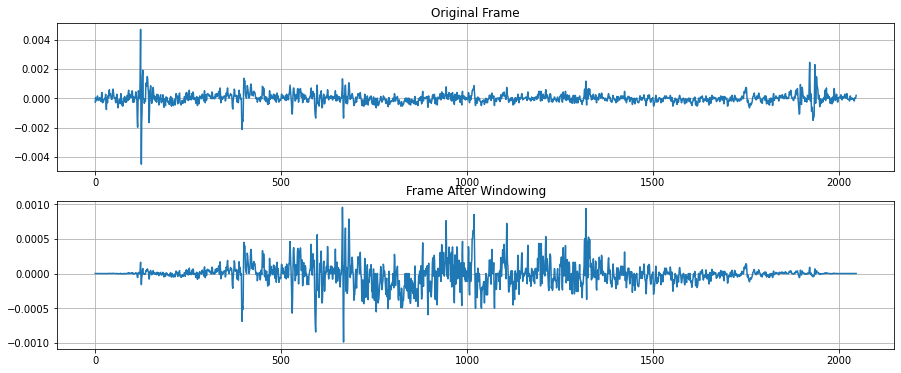

In [77]:
audio_win = audio_framed * window

ind = 5
plt.figure(figsize=(15,6))
plt.subplot(2, 1, 1)
plt.plot(audio_framed[ind])
plt.title('Original Frame')
plt.grid(True)
plt.subplot(2, 1, 2)
plt.plot(audio_win[ind])
plt.title('Frame After Windowing')
plt.grid(True)

In [78]:
audio_winT = np.transpose(audio_win)

audio_fft = np.empty((int(1 + FFT_size // 2), audio_winT.shape[1]), dtype=np.complex64, order='F')

for n in range(audio_fft.shape[1]):
    audio_fft[:, n] = fft.fft(audio_winT[:, n], axis=0)[:audio_fft.shape[0]]

audio_fft = np.transpose(audio_fft)

In [79]:
audio_power = np.square(np.abs(audio_fft))
print(audio_power.shape)

(51, 1025)


In [80]:
freq_min = 0
freq_high = sample_rate / 2
mel_filter_num = 10

print("Minimum frequency: {0}".format(freq_min))
print("Maximum frequency: {0}".format(freq_high))

Minimum frequency: 0
Maximum frequency: 8000.0


In [83]:
filter_points, mel_freqs = get_filter_points(freq_min, freq_high, mel_filter_num, FFT_size, sample_rate=16000)
filter_points

MEL min: 0.0
MEL max: 2840.023046708319


array([   0,   23,   52,   88,  134,  192,  264,  355,  470,  614,  796,
       1024])

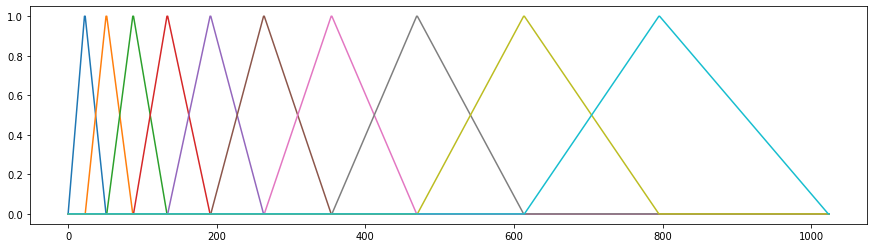

In [85]:
filters = get_filters(filter_points, FFT_size)

plt.figure(figsize=(15,4))
for n in range(filters.shape[0]):
    plt.plot(filters[n])

In [86]:
# taken from the librosa library
enorm = 2.0 / (mel_freqs[2:mel_filter_num+2] - mel_freqs[:mel_filter_num])
filters *= enorm[:, np.newaxis]

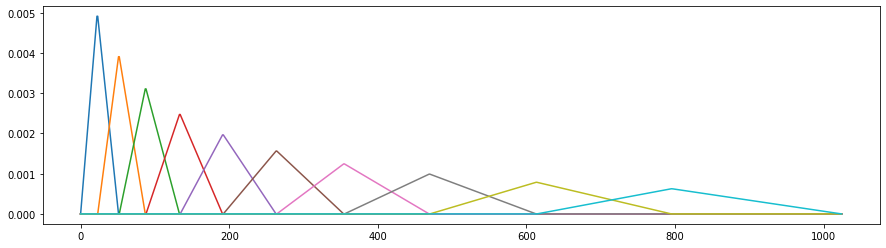

In [87]:
plt.figure(figsize=(15,4))
for n in range(filters.shape[0]):
    plt.plot(filters[n])

In [88]:
audio_filtered = np.dot(filters, np.transpose(audio_power))
audio_log = 10.0 * np.log10(audio_filtered)
audio_log.shape

(10, 51)

In [90]:
dct_filter_num = 13

dct_filters = dct(dct_filter_num, mel_filter_num)

cepstral_coefficents = np.dot(dct_filters, audio_log)
cepstral_coefficents.shape

(13, 51)

In [100]:
print(len(audio_framed))
print(len(audio_framed[0]))

51
2048


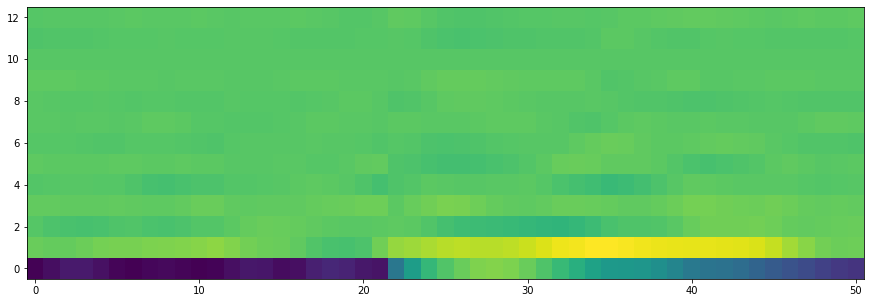

In [102]:
plt.figure(figsize=(15,5))
# plt.plot(np.linspace(0, len(audio) / sample_rate, num=len(audio)), audio)
plt.imshow(cepstral_coefficents, aspect='auto', origin='lower');

MEL min: 0.0
MEL max: 2840.023046708319


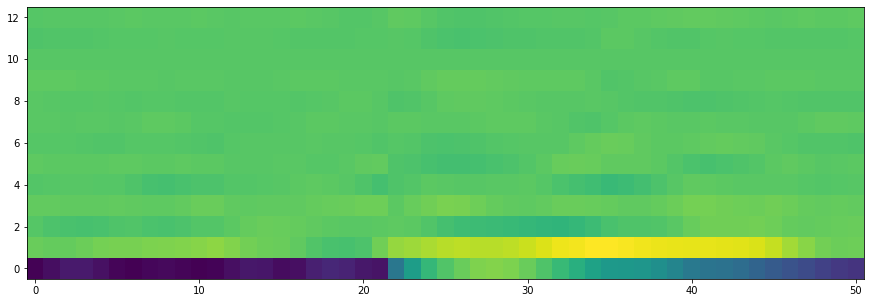

In [119]:
test_file = path + file_names[0]
mfcc = get_mfcc(test_file)

plt.figure(figsize=(15,5))
plt.imshow(mfcc, aspect='auto', origin='lower');

MEL min: 0.0
MEL max: 2840.023046708319
32


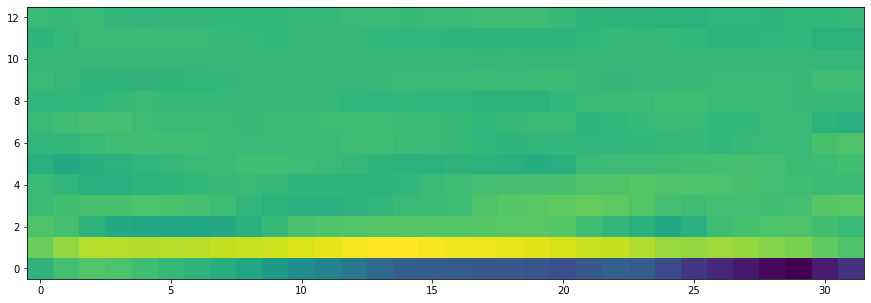

In [121]:
test_file = path + file_names[4]
mfcc = get_mfcc(test_file,hop_size=32)
print(len(mfcc[0]))
plt.figure(figsize=(15,5))
plt.imshow(mfcc, aspect='auto', origin='lower');